<a href="https://colab.research.google.com/github/kavyaajain16/PINN-LiteNet/blob/main/PINN_LiteNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 500 | Loss: 8.0377e-04
Epoch 1000 | Loss: 1.4474e-04
[INFO] Added 40 new collocation points based on residual error.
Epoch 1500 | Loss: 1.2233e-04
Epoch 2000 | Loss: 7.7848e-05
[INFO] Added 40 new collocation points based on residual error.
Epoch 2500 | Loss: 5.1562e-05
Epoch 3000 | Loss: 2.5865e-05
[INFO] Added 40 new collocation points based on residual error.
Epoch 3500 | Loss: 1.3651e-05
Epoch 4000 | Loss: 4.8731e-06
[INFO] Added 40 new collocation points based on residual error.
Epoch 4500 | Loss: 3.9448e-06
Epoch 5000 | Loss: 1.0345e-06
[INFO] Added 40 new collocation points based on residual error.

Relative L2 error: 2.4342e-04


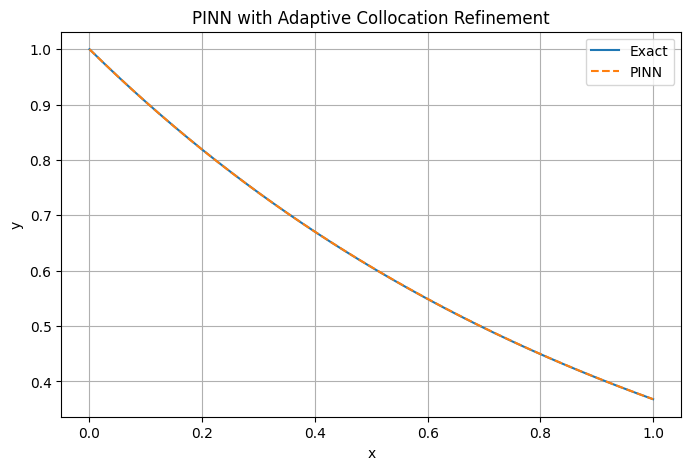

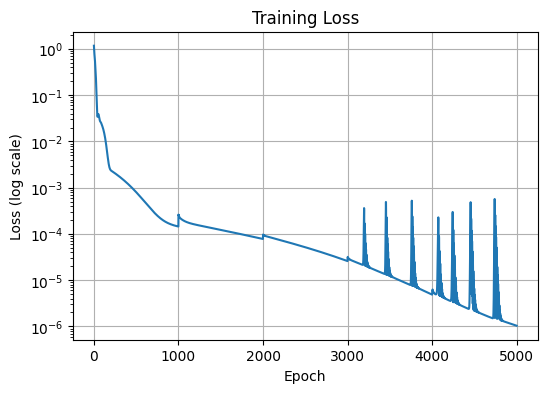

[INFO] Model saved as PINN_ACPR_MODEL.keras


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

# Domain
X_lower, X_upper = 0.0, 1.0

# Initial collocation points
N_initial = 200
x_collocation = np.random.uniform(X_lower, X_upper, (N_initial, 1)).astype(np.float32)

# Initial Condition
x_ic = np.array([[0.0]], dtype=np.float32)
y_ic = np.array([[1.0]], dtype=np.float32)

# Neural network model
def build_model(hidden_layers=(20,20,20)):
    inputs = tf.keras.Input(shape=(1,))
    x = inputs
    for width in hidden_layers:
        x = layers.Dense(width, activation='tanh')(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Physics-based loss
@tf.function
def train_step(x_batch):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_batch)
        y_pred = model(x_batch, training=True)
        dy_dx = tape.gradient(y_pred, x_batch)

        # Residual R = dy/dx + y
        residual = dy_dx + y_pred
        loss_res = tf.reduce_mean(tf.square(residual))

        # Initial condition loss
        y0_pred = model(x_ic, training=True)
        loss_ic = tf.reduce_mean(tf.square(y0_pred - y_ic))

        loss = loss_res + loss_ic

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, loss_res, loss_ic, tf.squeeze(residual)

# Function: Adaptive collocation refinement
def adaptive_refinement(num_new_points=50):
    global x_collocation

    # Evaluate residuals
    x_test_np = np.linspace(X_lower, X_upper, 500)[:, None].astype(np.float32)
    x_test = tf.convert_to_tensor(x_test_np) # Convert numpy array to TensorFlow tensor
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_test)
        y_pred = model(x_test)
        dy_dx = tape.gradient(y_pred, x_test)
    res = np.abs(dy_dx.numpy() + y_pred.numpy()).flatten()

    # Select top high-error points
    idx = np.argsort(res)[-num_new_points:]
    new_points = x_test_np[idx] # Use the original numpy array for indexing

    # Add to collocation set
    x_collocation = np.vstack([x_collocation, new_points])
    print(f"[INFO] Added {num_new_points} new collocation points based on residual error.")

# Training Loop
loss_history = []
epochs = 5000
refinement_interval = 1000  # Add new points every 1000 epochs

for epoch in range(1, epochs + 1):

    loss, loss_res, loss_ic, _ = train_step(tf.convert_to_tensor(x_collocation))

    loss_history.append(loss.numpy())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.numpy():.4e}")

    # Adaptive collocation
    if epoch % refinement_interval == 0:
        adaptive_refinement(num_new_points=40)

# Evaluate
x_test = np.linspace(X_lower, X_upper, 200)[:, None].astype(np.float32)
y_pred = model(tf.convert_to_tensor(x_test))
y_exact = np.exp(-x_test)

# Error
l2_error = np.linalg.norm(y_exact - y_pred, 2) / np.linalg.norm(y_exact, 2)
print(f"\nRelative L2 error: {l2_error:.4e}")

# Plot solution
plt.figure(figsize=(8,5))
plt.plot(x_test, y_exact, label='Exact')
plt.plot(x_test, y_pred, '--', label='PINN')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid()
plt.title("PINN with Adaptive Collocation Refinement")
plt.show()

# Plot training loss
plt.figure(figsize=(6,4))
plt.semilogy(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid()
plt.show()

# Save model
model.save("PINN_ACPR_MODEL.keras")
print("[INFO] Model saved as PINN_ACPR_MODEL.keras")